<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Dataset" data-toc-modified-id="Load-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Dataset</a></span></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Processing</a></span></li><li><span><a href="#the-customer-who-bought-the-most-items-overall-in-her-lifetime" data-toc-modified-id="the-customer-who-bought-the-most-items-overall-in-her-lifetime-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>the customer who bought the most items overall in her lifetime</a></span></li><li><span><a href="#for-each-item,-the-customer-who-bought-that-product-the-most" data-toc-modified-id="for-each-item,-the-customer-who-bought-that-product-the-most-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>for each item, the customer who bought that product the most</a></span></li><li><span><a href="#Cluster-items-based-on-user-co-purchase-history.-That-is,-create-clusters-of-products-that-have-the-highest-probability-of-being-bought-together." data-toc-modified-id="Cluster-items-based-on-user-co-purchase-history.-That-is,-create-clusters-of-products-that-have-the-highest-probability-of-being-bought-together.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together.</a></span></li></ul></div>

In [74]:
# import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import itertools

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize

%matplotlib inline

# Load Dataset 

In [40]:
# import item 
item = pd.read_csv('item_to_id.csv')
item

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39
5,dinner rolls,37
6,tortillas,34
7,bagels,13
8,canned vegetables,28
9,spaghetti sauce,26


In [5]:
# import purchase history 
purchase_history = pd.read_csv('purchase_history.csv')
purchase_history.head(3)

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"


In [6]:
purchase_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


# Data Processing

In [7]:
def id_to_item(df):
    """ function to convert id into counts """
    # 'sum' here is adding two lists into one big list
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1, 49)]
    for i in ids:
        id_list[int(i) - 1] += 1
        
    return pd.Series(id_list, index=list(range(1, 49)))

In [8]:
# get user_item count matrix
user_item_count = purchase_history.groupby('user_id').apply(id_to_item)
user_item_count.head(3)

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


# the customer who bought the most items overall in her lifetime

In [9]:
purchase_time = []
purchase_item = []
for i in range(len(purchase_history)):
    purchase_item.append(purchase_history['id'][i].split(','))
    purchase_time.append(len(purchase_history['id'][i].split(',')))
print('done!')

done!


In [10]:
purchase_history['purchase_item'] = purchase_item
purchase_history['purchase_time'] = purchase_time
purchase_history.head(3)

,user_id,id,purchase_item,purchase_time
0,222087,"27,26","[27, 26]",2
1,1343649,"6,47,17","[6, 47, 17]",3
2,404134,"18,12,23,22,27,43,38,20,35,1","[18, 12, 23, 22, 27, 43, 38, 20, 35, 1]",10


In [11]:
purchase_history.groupby('user_id')[['purchase_time']].sum().sort_values(
    'purchase_time', ascending=False).head(5)

,purchase_time
user_id,
269335,72
367872,70
397623,64
599172,64
377284,63


Customer 269335 bought most items (72)

# for each item, the customer who bought that product the most

In [19]:
# the most frequent item buyer and its name 
item_user_most = user_item_count.apply(np.argmax, axis=0).reset_index().rename(columns={'index': 'Item_id', 0: 'User_id'})
pd.merge(item_user_most,item)

,Item_id,User_id,Item_name
0,1,512,sugar
1,2,512,lettuce
2,3,2552,pet items
3,4,92,baby items
4,5,3605,waffles
5,6,5555,poultry
6,7,2926,sandwich bags
7,8,2493,butter
8,9,4445,soda
9,10,10238,carrots


# Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together.

In [44]:
# define feature matrix 
# build item-item similarity matrix 
item_item = pd.merge(user_item_count.T,item,left_index = True,right_on = 'Item_id')
item_item.drop(columns = 'Item_id',inplace = True)
item_item.set_index('Item_name',inplace = True)
item_item.head(3)

,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
Item_name,,,,,,,,,,,,,,,,,,,,,
sugar,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
lettuce,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
pet items,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [51]:
# build similarity matrix
item_norm = normalize(item_item, axis=1)
simi_item = pd.DataFrame(np.dot(item_norm, item_norm.T),
             index=item_item.index,
             columns=item_item.index)
simi_item.head()

Item_name,sugar,lettuce,pet items,baby items,waffles,poultry,sandwich bags,butter,soda,carrots,...,sandwich loaves,berries,ketchup,cucumbers,coffee,broccoli,cauliflower,bananas,pork,yogurt
Item_name,,,,,,,,,,,,,,,,,,,,,
sugar,1.000000,0.506895,0.420145,0.296986,0.271132,0.388250,0.271743,0.335303,0.403690,0.390641,...,0.388034,0.390286,0.358599,0.393056,0.395696,0.396766,0.390253,0.394998,0.392164,0.328221
lettuce,0.506895,1.000000,0.466874,0.322744,0.285125,0.468199,0.312200,0.390521,0.464872,0.527894,...,0.462968,0.462548,0.409401,0.529100,0.464579,0.527325,0.521058,0.462407,0.460257,0.380077
pet items,0.420145,0.466874,1.000000,0.277325,0.224537,0.358326,0.238133,0.301868,0.362091,0.352597,...,0.351093,0.368199,0.309078,0.357794,0.351209,0.362522,0.361922,0.354933,0.351832,0.297972
baby items,0.296986,0.322744,0.277325,1.000000,0.162860,0.247414,0.166012,0.216166,0.252662,0.258313,...,0.245623,0.261272,0.210767,0.244946,0.253282,0.253119,0.250190,0.253835,0.260541,0.218717
waffles,0.271132,0.285125,0.224537,0.162860,1.000000,0.233618,0.164699,0.203245,0.239445,0.234254,...,0.235543,0.238557,0.211006,0.238466,0.235064,0.241835,0.238087,0.238247,0.232387,0.188269


In [54]:
# find top-k most similar item 

def find_topk(item,k):
    df = simi_item.loc[item].sort_values(ascending=False)[1:k + 1].reset_index()
    df = df.rename(columns={item: 'Similarity'})
    return df

In [56]:
find_topk('ketchup',10)

,Item_name,Similarity
0,spaghetti sauce,0.409777
1,lettuce,0.409401
2,canned vegetables,0.400699
3,sugar,0.358599
4,cucumbers,0.342172
5,pork,0.341416
6,beef,0.340904
7,cauliflower,0.340783
8,apples,0.338978
9,poultry,0.338488


In [63]:
pca = PCA()
# rotate by PCA, making it easier to be visualized later
items_rotated = pca.fit_transform(simi_item)
items_rotated = pd.DataFrame(items_rotated,
                             index=item_item.index)
items_rotated

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
Item_name,,,,,,,,,,,,,,,,,,,,,
sugar,0.355639,-0.025103,-0.051129,-0.039214,-0.049529,0.003300,0.019830,-0.011458,0.084798,-0.042284,...,-0.019760,-0.012837,-0.006332,-0.022289,-0.002654,-0.001332,0.011263,-0.026911,-0.129284,9.369563e-17
lettuce,0.793894,-0.041103,0.013244,-0.009035,-0.141627,-0.036540,-0.114816,-0.087070,0.000959,-0.035030,...,-0.039028,-0.015895,-0.027280,0.017406,0.013680,0.004437,-0.030161,0.006713,0.379136,9.369563e-17
pet items,0.135668,-0.029584,-0.028246,-0.012556,-0.013317,0.004220,-0.020503,-0.050246,0.177599,-0.080864,...,0.020455,-0.007168,0.040652,0.004387,0.029288,0.000224,0.009908,0.001288,-0.035429,9.369563e-17
baby items,-0.532034,0.020259,-0.022628,-0.037650,0.022756,-0.046219,0.042124,-0.132828,0.651482,-0.274771,...,0.000133,0.002444,0.005894,-0.003617,-0.005383,0.001555,-0.006114,0.007527,0.020217,9.369563e-17
waffles,-0.678770,-0.093874,-0.347623,-0.232866,-0.090366,-0.057124,-0.018074,0.038866,-0.048059,-0.014378,...,-0.008466,0.011890,0.002598,0.007605,0.009321,-0.003278,0.006540,0.000677,0.023603,9.369563e-17
poultry,0.312811,-0.036128,0.044851,0.017309,-0.035048,0.080819,-0.047894,-0.021530,0.119243,0.409097,...,-0.020227,0.037458,-0.003532,-0.068856,0.111363,0.038920,-0.179474,0.195229,-0.039911,9.369563e-17
sandwich bags,-0.550273,-0.188354,0.058120,0.381101,-0.032518,-0.001882,-0.036626,-0.035533,-0.078704,0.033615,...,-0.003264,0.000230,-0.004935,0.009531,0.007640,0.003959,0.010467,0.000722,0.013446,9.369563e-17
butter,-0.052373,0.402611,-0.084719,0.101044,0.061785,0.033619,-0.072494,-0.017836,-0.039679,0.006366,...,0.005499,-0.024467,-0.008533,-0.014347,0.004348,-0.003086,0.009040,-0.013534,-0.003083,9.369563e-17
soda,0.337225,-0.088904,-0.039285,-0.046014,-0.062167,0.323283,0.195053,-0.089987,-0.061351,-0.085907,...,0.005030,0.248475,0.074118,-0.045950,-0.022483,-0.111802,-0.022843,-0.095708,0.006773,9.369563e-17


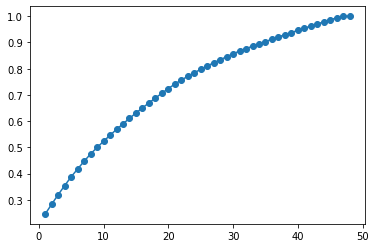

In [64]:
# show the total variance which can be explained by first K principle components
explained_variance_by_k = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,len(explained_variance_by_k)+1),explained_variance_by_k,marker="o")

In [78]:
def show_clusters(items_rotated,labels):
    """
    plot and print clustering result
    """
    fig = plt.figure(figsize=(15, 15))
    colors =  itertools.cycle (["b","g","r","c","m","y","k"])

    grps = items_rotated.groupby(labels)
    for label,grp in grps:
        plt.scatter(grp['1'],grp['2'],c=next(colors),label = label)

        names = items.loc[ grp.index,"Item_name"]
        for index, name in enumerate(names):
            print(index+1,name)

    # annotate
    for itemid in items_rotated.index:
        x = items_rotated.loc[itemid]
        y = items_rotated.loc[itemid]
        name = items.loc[itemid,"Item_name"]
        name = re.sub('\W', ' ', name)
        plt.text(x,y,name)

    # plt.legend(loc="best")

In [79]:
def cluster(n_clusters,n_components=48):
    """
    n_components=K, means use first K principle components in the clustering
    n_clusters: the number of clusters we want to cluster
    """
    print(n_components,100 * sum(pca.explained_variance_ratio_[:n_components]))

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(items_rotated.values[:, :n_components])

    # display results
    show_clusters(items_rotated, kmeans.labels_)


In [80]:
# choose best K (i.e., number of clusters)
inertias = []
silhouettes = []

ks = range(2,30)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(items_rotated)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(items_rotated, kmeans.predict(items_rotated)))

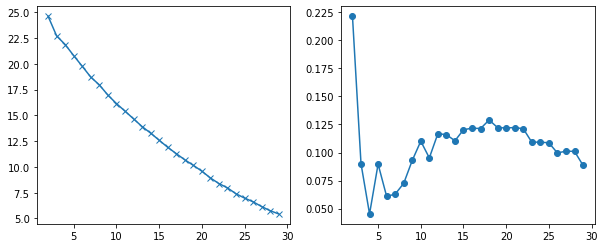

In [81]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.plot(ks,inertias,marker='x')# want to use elbow method to find best k

fig.add_subplot(1,2,2)
plt.plot(ks,silhouettes,marker='o')# the higher the bettercluster(n_clusters=15)

based on above plots, either elbow method nor silhouette_score can give better hint about the number of clusters . I decide to try multiple K, and choose the best one according to common sense.